In [1]:
import numpy as np 
import pandas as pd 
import scipy.io
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load the data
data = scipy.io.loadmat('Downloads/input.mat')
data = data['x']
data = data[0]

labels = scipy.io.loadmat('Downloads/class_label.mat')
labels = labels['y']

In [3]:
# Normalize 
for i in range(len(data)):
    data[i] = data[i]/np.max(data[i])

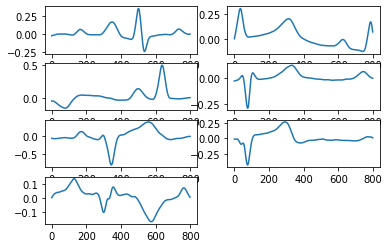

In [4]:
# Plotting one signal from each class
indices = [0, 3000, 6000, 9000, 12000, 15000, 17000]

for i in range(len(indices)):
    plt.subplot(4,2,i+1)
    signal = data[indices[i]]
    plt.plot(signal[5,:])


In [5]:
# Data Loader Class
class SignalsDataset(Dataset):

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        sample = {}
        
        sample['data'] = self.data[idx]     
        sample['data'] = torch.from_numpy(sample['data'])
        sample['label'] = self.labels[idx]

        return sample

In [6]:
batch_size = 60

In [7]:
dataset = SignalsDataset(data, labels)
idx = np.array([i for i in range(len(labels))])
np.random.shuffle(idx)

train_idx = idx[:int(0.7*len(idx))]
val_idx = idx[int(0.7*len(idx)) : int(0.8*len(idx))]
test_idx = idx[int(0.8*len(idx)):]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_load = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = 0)
val_load = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = 0)
test_load = DataLoader(dataset, batch_size = batch_size, sampler = test_sampler, num_workers = 0)

17160
12012
1716
3432


In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.ModuleList([nn.Conv1d(in_channels = 1, out_channels = 4, kernel_size = 32,stride = 1) 
                                    for i in range(12)])
        self.pool1 = nn.ModuleList([nn.MaxPool1d(2,return_indices = True) for i in range(12)])
        self.fc1 = nn.Linear(18432,1024)
        self.fc2 = nn.Linear(1024,18432)
        self.up = nn.ModuleList([nn.MaxUnpool1d(2) for i in range(12)])
        self.conv11 = nn.ModuleList([nn.ConvTranspose1d(in_channels = 4,out_channels = 1,kernel_size = 33,stride = 1) 
                                     for i in range(12)])

    def forward(self,X):
        
        # Encode
        fc_layers, indices = [], []
        for i in range(12):
            x = np.squeeze(X[:,i,:]) # Select ith channel
            x = x.view(x.size(0),1,-1) # Reshape as required
            x = F.relu(self.conv1[i](x)) # Conv
            x,ind = self.pool1[i](x) # Pool
            x = x.view(x.size(0),-1) # Flatten
            fc_layers.append(x) # Append flattened layer to list
            indices.append(ind) # Append pool indices to list
        
        # Concatenate flattened layers and pass them through fully connected layers
        concat = torch.cat([layer for layer in fc_layers], 1)
        fc = self.fc1(concat)
        concat = self.fc2(fc)
        
        s = fc_layers[0].shape[1] # size of each flattened layer
        
        # Split fully connected layer into components
        split_layers = []
        for i in range(12):
            split_layers.append(concat[:, i*s:(i+1)*s])
            
        split_layers = np.array(split_layers)
       
        # Decode each component
        deconv = []
        for i in range(12):
            x = split_layers[i]
            x = x.view(x.size(0),4,-1)
            x = self.up[i](x,indices[i])
            x = self.conv11[i](x)
            deconv.append(x)
        
        deconv = np.array(deconv)
        deconv = torch.cat([layer for layer in deconv], 1)
        
        return deconv, fc.squeeze()

In [9]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
model = model.to(device)

In [10]:
# Ignore
a = next(iter(train_load))
x = a['data'].float().cuda()
deconv, flat = model(x)

In [11]:
# Training function
def train(epoch):
    model.train()
    train_loss = 0
    for i, sample in enumerate(train_load):
        data = sample['data'].to(device)
        target = sample['data'].to(device) 
        data, target = data.squeeze(), target.squeeze()
        data, target = data.float(), target.float()
        
        optimizer.zero_grad()
        deconv, dense = model(data)
        
        loss = criterion(deconv, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print("Epoch {} \nTraining loss: {}".format(epoch+1, train_loss/len(train_idx)))

In [12]:
# Testing function
def val():
        
        model.eval()
        val_loss = 0
        
        for i, sample in enumerate(val_load):

            data = sample['data'].to(device)
            target = sample['data'].to(device) 
            data, target = data.squeeze(), target.squeeze()
            data, target = data.float(), target.float()
            
            deconv, dense = model(data)
            deconv, dense = deconv.detach(), dense.detach()
            loss = criterion(deconv, target)
            val_loss += loss.item()
            
        print("Validation loss: ", val_loss/len(val_idx))

In [13]:
for epoch in range(5):
    train(epoch)
    with torch.no_grad():
        val()
    print('\n')

Epoch 1 
Training loss: 0.00022644379381350912
Validation loss:  6.3497857934207e-05


Epoch 2 
Training loss: 3.5290030678507785e-05
Validation loss:  2.0584046836868624e-05


Epoch 3 
Training loss: 1.3543827501820327e-05
Validation loss:  1.0267541669732468e-05


Epoch 4 
Training loss: 7.785935557562587e-06
Validation loss:  6.460732882022901e-06


Epoch 5 
Training loss: 5.989508496377526e-06
Validation loss:  4.767431007627081e-06




Comparing output of autoencoder with original. Original signal on the left and reconstructed signal on the right

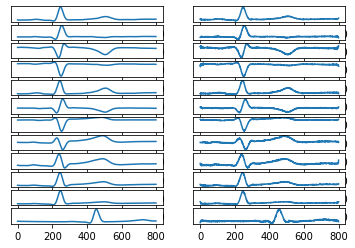

In [14]:
for i, sample in enumerate(train_load):
    
    if i==5: break
    
data = sample['data'].to(device)
data = data.squeeze()
data = data.float()
        
deconv, dense = model(data)
deconv, dense = deconv.detach(), dense.detach()
deconv = deconv.cpu().numpy()

original_signal = data.cpu().numpy()[0,:,:]
reconstructed_signal = deconv[0,:,:]

plt.figure
for i in range(12):
    plt.subplot(12, 2, 2*i+1)
    plt.plot(original_signal[i,:])
    plt.yticks([])
for i in range(12):
    plt.subplot(12, 2, 2*(i+1))
    plt.plot(reconstructed_signal[i,:])
    plt.yticks([])

## SVM Classifier
Extracting dense layers of training set

In [15]:
X_train = []
Y_train = []
for i, sample in enumerate(train_load):

    data = sample['data'].to(device)
    data = data.squeeze()
    data = data.float()
    
    labels = sample['label'].cpu().numpy()
    for label in labels:
        Y_train.append(label)
            
    deconv, dense = model(data)
    deconv, dense = deconv.detach(), dense.detach()
    dense = dense.cpu()
    
    for item in dense: 
        X_train.append(item.numpy())

X_train = np.array(X_train)
Y_train = np.array(Y_train).squeeze()

Extracting dense layers of evaluation set

In [16]:
X_val = []
Y_val = []
for i, sample in enumerate(val_load):
            
    data = sample['data'].to(device)
    data = data.squeeze()
    data = data.float()
    
    labels = sample['label'].cpu().numpy()
    for label in labels:
        Y_val.append(label)
            
    deconv, dense = model(data)
    deconv, dense = deconv.detach(), dense.detach()
    dense = dense.cpu()
    
    for item in dense: 
        X_val.append(item.numpy())
         
X_val = np.array(X_val)
Y_val = np.array(Y_val).squeeze()
Y_val.shape

(1716,)

Extracting dense layers of testing set

In [17]:
X_test = []
Y_test = []
for i, sample in enumerate(test_load):
            
    data = sample['data'].to(device)
    data = data.squeeze()
    data = data.float()
    
    labels = sample['label'].cpu().numpy()
    for label in labels:
        Y_test.append(label)
            
    deconv, dense = model(data)
    deconv, dense = deconv.detach(), dense.detach()
    dense = dense.cpu()
    
    for item in dense: 
        X_test.append(item.numpy())
         
X_test = np.array(X_test)
Y_test = np.array(Y_test).squeeze()

Linear kernel

In [18]:
# SVM training
clf = svm.SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(X_train, Y_train)

# Validation
svm_predictions = clf.predict(X_val)
accuracy = clf.score(X_val, Y_val)

cm = confusion_matrix(Y_val, svm_predictions)
print("Validation accuracy: ", accuracy)
print("Confusion Matrix: \n",cm)

Validation accuracy:  1.0
Confusion Matrix: 
 [[321   0   0   0   0   0   0]
 [  0 183   0   0   0   0   0]
 [  0   0 274   0   0   0   0]
 [  0   0   0 162   0   0   0]
 [  0   0   0   0 292   0   0]
 [  0   0   0   0   0 294   0]
 [  0   0   0   0   0   0 190]]


Polynomial kernel

In [19]:
clf = svm.SVC(decision_function_shape='ovo', kernel='poly')
clf.fit(X_train, Y_train)

svm_predictions = clf.predict(X_val)
accuracy = clf.score(X_val, Y_val)
cm = confusion_matrix(Y_val, svm_predictions)
print("Validation accuracy: ", accuracy)
print("Confusion Matrix: \n",cm)

Validation accuracy:  1.0
Confusion Matrix: 
 [[321   0   0   0   0   0   0]
 [  0 183   0   0   0   0   0]
 [  0   0 274   0   0   0   0]
 [  0   0   0 162   0   0   0]
 [  0   0   0   0 292   0   0]
 [  0   0   0   0   0 294   0]
 [  0   0   0   0   0   0 190]]


RBF kernel

In [20]:
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf')
clf.fit(X_train, Y_train)

svm_predictions = clf.predict(X_val)
accuracy = clf.score(X_val, Y_val)
cm = confusion_matrix(Y_val, svm_predictions)
print("Validation accuracy: ", accuracy)
print("Confusion Matrix: \n",cm)

Validation accuracy:  1.0
Confusion Matrix: 
 [[321   0   0   0   0   0   0]
 [  0 183   0   0   0   0   0]
 [  0   0 274   0   0   0   0]
 [  0   0   0 162   0   0   0]
 [  0   0   0   0 292   0   0]
 [  0   0   0   0   0 294   0]
 [  0   0   0   0   0   0 190]]


All the kernels work equally well. Testing the linear kernel classifier:

In [21]:
svm_predictions = clf.predict(X_test)
accuracy = clf.score(X_test, Y_test)
cm = confusion_matrix(Y_test, svm_predictions)
print("Testing accuracy: ", accuracy)
print("Confusion Matrix: \n",cm)

Testing accuracy:  1.0
Confusion Matrix: 
 [[559   0   0   0   0   0   0]
 [  0 373   0   0   0   0   0]
 [  0   0 549   0   0   0   0]
 [  0   0   0 332   0   0   0]
 [  0   0   0   0 608   0   0]
 [  0   0   0   0   0 616   0]
 [  0   0   0   0   0   0 395]]
